# Report of WTO import/export dataset

This report contains some summary statistics and graphs relating to the COMEXT dataset about import/export exchanges between countries. 
The steps that were done before the analysis are the following:
- combine I/E when regarding the same edge, with the mean;
- normalization by populationat each year (UN dataset), thus defining € pro capite as values;
- for every month, for every prod category, compute metrics graph-level and node-level;
- visual analysis of the network;
- AR Networks paper

## Code and functions

In [1]:
import os

colab = False
# #### COLAB ONLY CELL
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    # drive.mount('/content/gdrive',force_remount=True)
    os.chdir("/content/gdrive/MyDrive/COMEXT")
    !pip install -q -r world-trade-thesis/requirements.txt
    !pwd
else:
    os.chdir("H:/My Drive/COMEXT")
    !pwd

import random, math, os, pickle, sys, powerlaw, hashlib #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm, trange
from networkx.readwrite import json_graph
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler


if colab:
    sys.path.append('/content/gdrive/MyDrive/COMEXT/world-trade-thesis/src')
else:
    sys.path.append('H:/My Drive/COMEXT/world-trade-thesis/src')
import graph_analysis as g

/h/My Drive/COMEXT


In [2]:
df_pop, eu_iso = g.load_population_df()
complete_metrics_df = pd.read_parquet("./data-samples/metrics/metrics_complete_V_sbm2.parquet")

## Population analysis

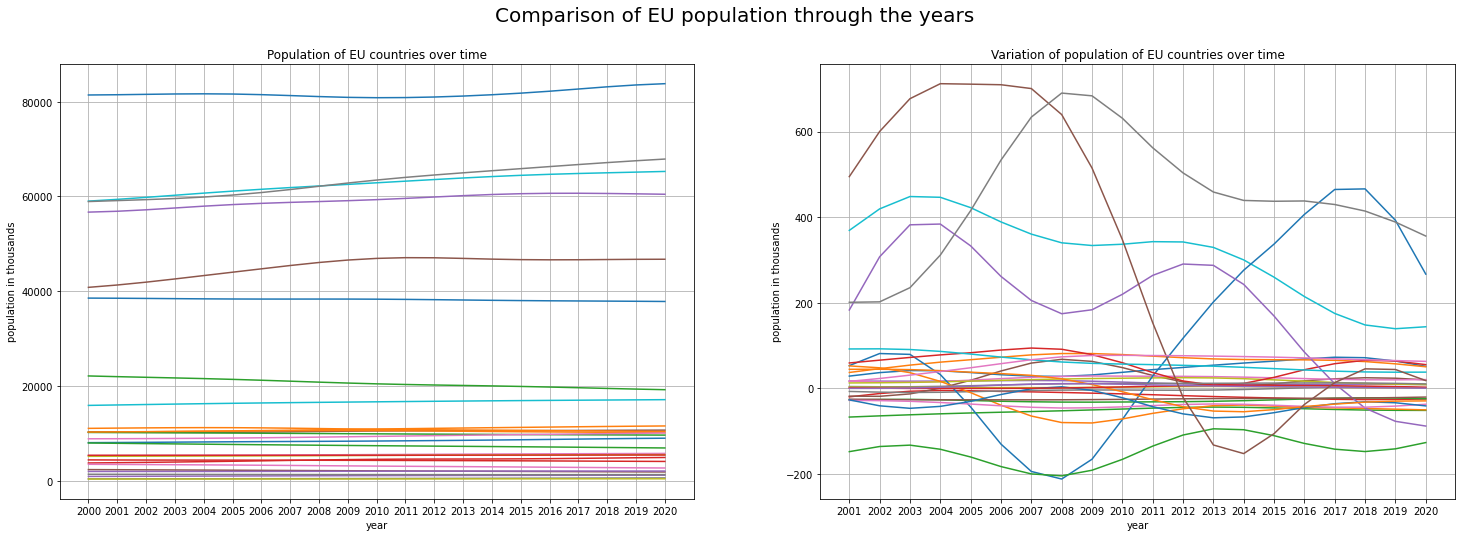

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
ax1.plot(df_pop.loc[eu_iso,:].transpose())
ax1.set_title("Population of EU countries over time")
ax1.set_ylabel("population in thousands")
ax1.set_xlabel("year")
ax1.grid()
# ax1.legend(loc="upper right")
ax2.plot(df_pop.diff(periods=1,axis=1).loc[eu_iso,:].transpose())
ax2.set_title("Variation of population of EU countries over time")
ax2.set_ylabel("population in thousands")
ax2.set_xlabel("year")
ax2.grid()
# ax2.legend(loc="upper right")
plt.suptitle("Comparison of EU population through the years",fontsize=20)
plt.show()

## Price analysis (general)

In [4]:
g.full_columns, g.full_types

(['PRODUCT_CPA2_1',
  'DECLARANT_ISO',
  'PARTNER_ISO',
  'FLOW',
  'PERIOD',
  'VALUE_IN_EUROS',
  'QUANTITY_IN_KG'],
 {'PRODUCT_CPA2_1': str,
  'DECLARANT_ISO': str,
  'PARTNER_ISO': str,
  'FLOW': int,
  'PERIOD': str,
  'VALUE_IN_EUROS': int,
  'QUANTITY_IN_KG': int})

In [5]:
def load_filtered_data(table, save=False, verbose=1, force_reload=False, sorted=True, **params):
    """"
    load_filtered_data("full", save=True, force_reload=True, columns=g.full_columns, types=g.full_types, 
                        group_by_prod_code=True, n_digits=2, years=[2012], months=None, product="all", 
                        flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

    table: str
    save: bool
    types: dict(type)
    columns: list
    group_by_prod_code: bool 
    n_digits: int
    years: list(int)
    months: list(int) | None | "all"
    product: "all" | list(str) 
    flow: 1 | 2 | "all"
    trade_type: "I" | "E" | "all"
    declarant_iso: str | "all"
    partner_iso: str | "all"

    Returns
        (pd.DataFrame, str)
    """
    
    if verbose:
        print("loading",table,end=": ")

    def get_params_str_hash(params):
        str_params = {x:params[x] for x in params if x != "types"}
        # str_params = params
        # return str(str_params).replace("{","").replace("}","").replace("': ","_").replace("[","").replace("]","").replace(", ","_").replace("'","").replace("<class ","").replace(">","")
        return hashlib.sha256(str(str_params).encode("UTF_8")).hexdigest()

    def group_by_prod_code(table,**params):
        df = table.copy()
        column = df.columns[0]
        df[column] = df[column].str[:params["n_digits"]]
        return df.groupby(params["columns"][:-2],as_index=False).sum()
    
    if not force_reload and os.path.exists(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"):
        if not os.path.exists(f"./data-samples/manual/{table}/"):
            os.makedirs(f"./data-samples/manual/{table}/")
        if verbose:
            print("loading existing...",end=" ")
        df = pd.read_parquet(f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet")
        if verbose:
            print("Table loaded")
        return df, None
    else:
        prod_code_df = params["columns"][0]

        def build_filters(df,params,table,name,prod_code_df):
            filters = pd.Series([True for i in range(df.shape[0])])
            if isinstance(params["product"],list):
                filter_prod = ~filters.copy()
                not_f = []
                for p in params["product"]:
                    mask = (df[prod_code_df] == p)
                    if not mask.any():
                        not_f.append(p)
                    filter_prod = filter_prod | mask
                if verbose==2 and len(not_f) > 0:
                    print(','.join(not_f),f"not found in {table}{name}",end=", ")
                filters = filters & filter_prod
            elif params["product"] != "all":
                mask = (df[prod_code_df] == params["product"])
                if verbose==2 and not mask.any():
                    print(f"{params['product']} not found in {table}{name}",end=", ")
                filters = filters & mask
            if params["flow"] != "all":
                filters = filters & (df.FLOW == params["flow"])
            if table == "full" and params["trade_type"] != "all":
                filters = filters & (df.TRADE_TYPE == params["trade_type"])
            if isinstance(params["declarant_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["declarant_iso"]:
                    mask = (df["DECLARANT_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["declarant_iso"] != "all":
                mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
            if isinstance(params["partner_iso"],list):
                filter_dec = ~filters.copy()
                for p in params["partner_iso"]:
                    mask = (df["PARTNER_ISO"] == p)
                    if verbose==2 and not mask.any():
                        print(f"{p} not found in {table}{name}",end=", ")
                    filter_dec = filter_dec | mask
                filters = filters & filter_dec
            elif params["partner_iso"] != "all":
                mask = (df["PARTNER_ISO"] == params["partner_iso"])
                if verbose==2 and not mask.any():
                    print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
            
            if verbose==2 and not filters.any():
                print(f"\n\tempty df for {table}{name}")

            return filters

        if table not in ["full","tr","tr_intra_","wto","complete"]:
            raise Exception("table not valid")
        df = pd.DataFrame(columns=params["columns"])
        for y in tqdm(params["years"],leave=False):
            if verbose:
                print(y,end=" ")
            if table == "complete":
                df_com = pd.read_parquet(f"./data-samples/full/Years/full{y}52.parquet",columns=params["columns"])
                df_wto = pd.read_parquet(f"./data-samples/wto/Years/wto{y}52.parquet",columns=params["columns"])
                df_y = g.combine_sources(df_com,df_wto)
                print(df_y[df_y.VALUE_IN_EUROS < 0].shape)
                return df_y, "", params, table, prod_code_df
                if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                    df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                else:
                    df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                print(df_y_filtered[df_y_filtered.VALUE_IN_EUROS < 0].shape)
                df = pd.concat([df,df_y_filtered])
                print(df[df.VALUE_IN_EUROS < 0].shape)
            else:
                if params["months"] is None:
                    df_y = pd.read_parquet(f"./data-samples/{table}/Years/{table}{y}52.parquet",columns=params["columns"])
                    if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                        df_y_filtered = group_by_prod_code(df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"]),**params)
                    else:
                        df_y_filtered = df_y[build_filters(df_y,params,table,str(y)+"52",prod_code_df)].astype(params["types"])
                    df = pd.concat([df,df_y_filtered])
                    del df_y, df_y_filtered
                elif params["months"] == "all":
                    for m in tqdm(range(1,13),leave=False):
                        # if verbose:
                        #     print(str(m),end=" ")
                        df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                        if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                            df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                        else:
                            df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                        df = pd.concat([df,df_y_filtered])
                    del df_ym, df_y_filtered
                else:
                    for m in params["months"]:
                        if verbose:
                            print(str(m),end=" ")
                        df_ym = pd.read_parquet(f"./data-samples/{table}/Months/{table}{y*100+m}.parquet",columns=params["columns"])
                        if "group_by_prod_code" in params.keys() and params["group_by_prod_code"]:
                            df_y_filtered = group_by_prod_code(df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"]),**params)
                        else:
                            df_y_filtered = df_ym[build_filters(df_ym,params,table,str(y*100+m),prod_code_df)].astype(params["types"])
                        df = pd.concat([df,df_y_filtered])
                    del df_ym, df_y_filtered
        if df.shape[0] == 0:
            if verbose:
                print("\n\tEmpty table")
            return df
        else:
            if sorted:
                df_out = df.astype(g.full_types).groupby(params["columns"][:-2],as_index=False).sum().sort_values(params["columns"][-2],ascending=False).reset_index(drop=True)
            else:
                df_out = df.astype(g.full_types).groupby(params["columns"][:-2],as_index=False).sum().reset_index(drop=True)
            str_save = f"./data-samples/manual/{table}/{table}__{get_params_str_hash(params)}.parquet"
            print(df_out[df_out.VALUE_IN_EUROS < 0].shape)
            if save:
                try:
                    df_out.to_parquet(str_save)
                    if verbose:
                        print(",\t Table loaded")
                    return df_out.astype(params["types"]), str_save
                except:
                    if verbose:
                        print("\nFailed saving",end="")
                        print(", Table loaded")
                    return df_out.astype(params["types"]), str_save
            else:
                return df_out.astype(params["types"]), str_save


def build_filters(df,params,table,name,prod_code_df,verbose=2):
    filters = pd.Series([True for i in range(df.shape[0])])
    if isinstance(params["product"],list):
        filter_prod = ~filters.copy()
        not_f = []
        for p in params["product"]:
            mask = (df[prod_code_df] == p)
            if not mask.any():
                not_f.append(p)
            filter_prod = filter_prod | mask
        if verbose==2 and len(not_f) > 0:
            print(','.join(not_f),f"not found in {table}{name}",end=", ")
        filters = filters & filter_prod
    elif params["product"] != "all":
        mask = (df[prod_code_df] == params["product"])
        if verbose==2 and not mask.any():
            print(f"{params['product']} not found in {table}{name}",end=", ")
        filters = filters & mask
    if params["flow"] != "all":
        filters = filters & (df.FLOW == params["flow"])
    if table == "full" and params["trade_type"] != "all":
        filters = filters & (df.TRADE_TYPE == params["trade_type"])
    if isinstance(params["declarant_iso"],list):
        filter_dec = ~filters.copy()
        for p in params["declarant_iso"]:
            mask = (df["DECLARANT_ISO"] == p)
            if verbose==2 and not mask.any():
                print(f"{p} not found in {table}{name}",end=", ")
            filter_dec = filter_dec | mask
        filters = filters & filter_dec
    elif params["declarant_iso"] != "all":
        mask = (df["DECLARANT_ISO"] == params["declarant_iso"])
        if verbose==2 and not mask.any():
            print(f"{params['declarant_iso']} not found in {table}{name}",end=", ")
    if isinstance(params["partner_iso"],list):
        filter_dec = ~filters.copy()
        for p in params["partner_iso"]:
            mask = (df["PARTNER_ISO"] == p)
            if verbose==2 and not mask.any():
                print(f"{p} not found in {table}{name}",end=", ")
            filter_dec = filter_dec | mask
        filters = filters & filter_dec
    elif params["partner_iso"] != "all":
        mask = (df["PARTNER_ISO"] == params["partner_iso"])
        if verbose==2 and not mask.any():
            print(f"{params['partner_iso']} not found in {table}{name}",end=", ")
    
    if verbose==2 and not filters.any():
        print(f"\n\tempty df for {table}{name}")


In [ ]:
df_y, _ , params, table, prod_code_df = load_filtered_data("complete", save=True, verbose=2, sorted=False, force_reload=True, types=g.full_types, columns=g.full_columns, group_by_prod_code=False, n_digits=2,
                             years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
# df_full["PRICE"] = df_full["VALUE_IN_EUROS"] / df_full["QUANTITY_IN_KG"]

In [ ]:
df_y[build_filters(df_y,params,table,str(2001)+"52",prod_code_df)]#.astype(params["types"])

In [ ]:
df_com = pd.read_parquet("data-samples/full/Years/full200152.parquet",columns=g.full_columns)
df_wto = pd.read_parquet("data-samples/wto/Years/wto200152.parquet",columns=g.full_columns)
df_neg = combine_sources(df_com, df_wto)

In [ ]:
# for df in [df_com, df_wto, df_neg]:
print(df[(df.VALUE_IN_EUROS < 0 )])

In [ ]:
df_complete["2code"] = df_complete.PRODUCT_CPA2_1.str[:2]
df_complete.groupby(["2code","DECLARANT_ISO","PARTNER_ISO"],as_index=False)["VALUE_IN_EUROS"].sum().sort_values("VALUE_IN_EUROS")

In [ ]:
df4g = g.extract_table_for_graph(df_complete,y='2001',scale_by="population")

In [ ]:
df_complete[(df_complete.DECLARANT_ISO=="IT")]#[["PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]].set_index("PARTNER_ISO")#.plot.bar(figsize=(40,8))
# plt.title("Italian TOTAL imports in 2021, difference between value and quantity",fontsize=20)
# plt.legend(loc="upper center")
# plt.grid()
# plt.show()

In [ ]:
df_full[(df_full.FLOW==2)&(df_full.DECLARANT_ISO=="IT")][["PARTNER_ISO","VALUE_IN_EUROS","QUANTITY_IN_KG"]].set_index("PARTNER_ISO").plot.bar(figsize=(40,8))
plt.title("Italian TOTAL exports in 2021, difference between value and quantity",fontsize=20)
plt.legend(loc="upper center")
plt.grid()
plt.show()

## Threshold Analysis

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(np.log10(df_full.VALUE_IN_EUROS[df_full.VALUE_IN_EUROS >0]),bins=100)
plt.title("Log distribution of the value of TOTAL exchanges in 2021")
plt.grid()
plt.show()

In [ ]:
df_full.sort_values("VALUE_IN_EUROS",ascending=False).head()

In [ ]:
thresholds = {str(y):{} for y in range(2001,2021)}
for y in trange(2001,2021):
    df_full, _ = g.load_filtered_data("complete", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                    years=[y], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")
    for prod in tqdm(df_full.PRODUCT_CPA2_1.unique(),leave=False):
        df4g = df_full[df_full.PRODUCT_CPA2_1 == prod]
        df_full_scaled = g.extract_table_for_graph(df4g, y=str(y), flow="all", scale_by="population",pop_df=df_pop)
        df7 = df_full_scaled.sort_values("VALUE_IN_EUROS_SCALED",ascending=False).reset_index(drop=True)
        df7 = df7[df7.VALUE_IN_EUROS_RESCALED.cumsum() < 0.9999]
        thresholds[str(y)][prod] = df7.iloc[-1,-4]
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8),sharey=True)
# ax1.hist(np.log10(df_full_scaled.VALUE_IN_EUROS_SCALED[df_full_scaled.VALUE_IN_EUROS_SCALED > 0]),bins=100)
# ax1.vlines(np.log10(df7.iloc[-1,-4]),0,300,label=f"Threshold = {np.log10(df7.iloc[-1,-4])}€/person")
# ax1.set_xlabel("Logarithm of value of exchange in €")
# ax1.set_title("Without threshold")
# ax1.legend()
# ax1.grid()
# ax2.hist(np.log10(df7.VALUE_IN_EUROS_SCALED[df7.VALUE_IN_EUROS_SCALED > 0]),bins=100,range=(-4,8))
# ax2.vlines(np.log10(df7.iloc[-1,-4]),0,300,label=f"Threshold = {np.log10(df7.iloc[-1,-4])}€/person")
# ax2.set_xlabel("Logarithm of value of exchange in €")
# ax2.set_title("With threshold")
# ax2.grid()
# ax2.legend()
# plt.suptitle("Histogram of the value of exchanges, in logarithm")
# plt.show()

In [ ]:
pd.DataFrame(thresholds).to_csv("data-samples/manual/complete_thresholds.csv")

Before thresholding the distribution was as above, with a considerable number of left tail values that are very low. After rescaling the values get truncated to the left with a cutoff of around 10 euro pro capite

In [ ]:
# Thresholding by quantile
q = 0.05
print("Threshold value at", 10**np.log10(df_full_scaled.VALUE_IN_EUROS_SCALED[df_full_scaled.VALUE_IN_EUROS_SCALED>0]).quantile(q))
print("Actual:",end=" ")
df_full_scaled[df_full_scaled.VALUE_IN_EUROS_SCALED > df_full_scaled.VALUE_IN_EUROS_SCALED.quantile(q)].sort_values("VALUE_IN_EUROS_SCALED",ascending=False).iloc[-1,-4]

In [ ]:
# Thresholding by cumsum
df7 = df_full_scaled.sort_values("VALUE_IN_EUROS_SCALED",ascending=False).reset_index(drop=True)
print("Threshold value at:",end=" ")
df7[df7.VALUE_IN_EUROS_RESCALED.cumsum() < 0.999].iloc[-1,-4]

## Analysis of graph metrics across categories

### Mean Density across time

In [ ]:
g.plot_bar_metr(complete_metrics_df,metr="density",log=False)

#### Category Time series

In [ ]:
for i in range(100):
    print(f"{i:02d}",g.get_cat_name("full",f"{i:02d}"))

In [ ]:
df_complete_2020, _ = g.load_filtered_data("wto", save=True, verbose=2, sorted=False, force_reload=False, types=g.full_types, columns=g.full_columns, group_by_prod_code=True, n_digits=2,
                             years=[2020], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

In [ ]:
# !pip install --user --upgrade numpy scipy pandas networkx

In [ ]:
code = "10"
year = "2019"
category = g.get_cat_name("full",code)

In [ ]:
tab_nodes = pd.DataFrame(g.get_world_countries(df_pop, eu_iso, year)).set_index(0)

In [ ]:
df4g = df_complete_2020[df_complete_2020.PRODUCT_CPA2_1 == code].copy()
t4g = g.extract_table_for_graph(df4g, y=year, flow="all", scale_by='population', pop_df=df_pop)
coord, metrics, G = g.makeGraph(t4g, weight_flag=True, compute_layout=True, lay_dist=150, compute_metrics=False)
plt.figure(figsize=(20,15),dpi=200,facecolor="w")
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256+30 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/60 for i in edg_color], font_color="white", font_size=10, node_size=300, node_color=["tab:blue" if tab_nodes.loc[c,1]["eu"] else "tab:red" for c in G.nodes()])
plt.title(f"Network of exchanges of {category} in {year}",fontsize=20)
plt.show()

In [ ]:
g.plot_cat_ts(complete_metrics_df, metr="in_weight_degree", prod="26", moving_avg=None, country="IT")

In [ ]:
g.plot_cat_ts(complete_metrics_df, metr="in_weight_degree", prod="26", moving_avg=None)

### Power law

In [ ]:
metrics_cat = complete_metrics_df[(complete_metrics_df["prod"] == code)]
metrics_cat_avg = metrics_cat.groupby(["country"],as_index=False).mean().set_index("country")

In [ ]:
metrics_cat_avg

In [ ]:
metrics_cat_avg.in_degree.sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.title(f"Top 25 countries by in degree of {category}, all time average",fontsize=20)
plt.show()

In [ ]:
metrics_cat_avg.in_weight_degree.sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.title(f"Top 25 countries by in weight degree of {category}, all time average",fontsize=20)
plt.show()

Possible Question:

How can we define dependence by looking at in degree and in weight degreee?
There are countries who import a lot but from a single supplier or countries that import from a lot of suppliers but a smaller quantity. How do we intergrate the two?

IDEA: look at stacked bar plot with percentages.
However, it's just qualitative. 

POWERLAW.FIT:

Returns the optimal xmin beyond which the scaling regime of the power
        law fits best. The attribute self.xmin of the Fit object is also set.
        The optimal xmin beyond which the scaling regime of the power law fits
        best is identified by minimizing the Kolmogorov-Smirnov distance
        between the data and the theoretical power law fit.
        This is the method of Clauset et al. 2007.

##### Degree

In [ ]:
g.plot_power_law(metrics_cat,"degree")

##### In degree

In [ ]:
g.plot_power_law(metrics_cat,"in_degree")

##### In weight degree

In [ ]:
g.plot_power_law(metrics_cat,"in_weight_degree")

##### Out degree

In [ ]:
g.plot_power_law(metrics_cat,"out_degree")

#### Out weight degree

In [ ]:
g.plot_power_law(metrics_cat,"out_weight_degree")

## Analysis for ITALY

Next I'll do an analysis following Italy's import/export through time

In [ ]:
ita = complete_metrics_df[(complete_metrics_df.country == "IT")&(complete_metrics_df["prod"] != "TO")]

In [ ]:
ita_pivot = ita[["year","month","prod","in_weight_degree"]].reset_index(drop=True).pivot(index=["year","month"], columns=["prod"]).droplevel(0,1)

In [ ]:
g.plot_bar_metr(complete_metrics_df,country="IT",metr="in_weight_degree",log=False)
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.show()

In [ ]:
g.plot_bar_metr(complete_metrics_df,country="IT",metr="in_weight_degree_gamma",log=False)
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.show()

### Metrics plot ts

In [ ]:
df_complete_cat, _ = g.load_filtered_data("wto", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                            years=[y for y in range(2001,2021)], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

In [ ]:
g.plot_cat_ts(complete_metrics_df,code,"in_weight_degree","IT",moving_avg=None,log=False)

In [ ]:
g.plot_cat_ts(complete_metrics_df,code,"in_degree","IT",moving_avg=None)

In [ ]:
g.plot_cat_ts(complete_metrics_df,code,"in_weight_degree","IT",moving_avg=None,log=True)
g.plot_cat_ts(complete_metrics_df,code,"out_weight_degree","IT",moving_avg=None,log=True)

In [ ]:
g.plot_cat_ts(complete_metrics_df,code,"in_weight_degree","IT",moving_avg=None,log=False)

In [ ]:
g.plot_cat_ts(complete_metrics_df,code,"in_degree","IT",moving_avg=None,log=False)

In [ ]:
g.plot_bar_metr(complete_metrics_df,country="IT",metr="out_degree_gamma",log=False)

### Plots

In [ ]:
g.plot_bar_metr(complete_metrics_df,country="IT",metr="in_weight_degree",log=False)

In [ ]:
g.plot_bar_metr(complete_metrics_df,country="IT",metr="out_weight_degree",log=False)

### Food Products for Italy

In [ ]:
g.plot_cat_ts(complete_metrics_df,metr="in_weight_degree",prod=code,moving_avg=None,country="IT")
g.plot_cat_ts(complete_metrics_df,metr="out_weight_degree",prod=code,moving_avg=None,country="IT")
# plt.ylabel("weight_degree")
# plt.title("weight_degree"+" over time of "+g.get_cat_name("full","06")+" for "+"IT")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
g.plot_cat_ts(complete_metrics_df,metr="in_weight_degree",prod="TO",moving_avg=2,log=True)
# g.plot_cat_ts(full_metrics_df,metr="out_weight_abs",prod="TO",moving_avg=12,log=True)
plt.title("Total growth of exchanges across time for the world (in log)")
plt.show()

### 2012

In [ ]:
# df_full_2012, _ = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
#                              years=[2012], months=[1,2,3,4,5,6], product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

In [ ]:
# df_12_52, _ = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
#                              years=[2012], months=None, product=["0"+str(i) for i in range(600,699)], flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

In [ ]:
# df_full_2012.to_parquet("./data-samples/manual/full/df_full_2012_06.parquet")
# df_full_2012 = pd.read_parquet("./data-samples/manual/full/df_full_2012_06.parquet")

In [ ]:
# df_12_52[df_12_52.DECLARANT_ISO.isin(["IT","DE","FR"])&df_12_52.PARTNER_ISO.isin(["IT","FR","DE"])].sort_values("PERIOD")

In [ ]:
#@title
# df_full_2012[(df_full_2012.DECLARANT_ISO.isin(["IT","HR"]))&df_full_2012.PARTNER_ISO.isin(["IT","HR"])].sort_values(["PERIOD","FLOW"])

In [ ]:
# df_wto_2001 = g.load_filtered_data("wto", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
#                              years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

In [ ]:
# df_wto_2001_scaled = g.extract_table_for_graph(df_wto_2001,y="2012",scale_by="population",pop_df=df_pop)
# coord, metrics, G = g.makeGraph(df_wto_2001_scaled, tab_nodes=g.get_world_countries(df_pop, eu_iso, year=df_wto_2001_scaled.columns.name),\
#                                 weight_flag=True, compute_layout=True)
# plt.figure(figsize=(20,10))
# edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
# edg_color = [(i/max(edg_color))*256 for i in edg_color]
# nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/30+0.5 for i in edg_color], font_color="white", node_size=400)
# plt.show()